<a href="https://colab.research.google.com/github/cherrerav030895-glitch/Evaluacion-formativa-8-RF/blob/main/Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Depth: Decision Trees and Random Forests

# En profundidad: Árboles de decisión y Bosques aleatorios

Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at another powerful algorithm: a nonparametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning one that relies on aggregating the results of a set of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, the predictive accuracy of a majority vote among a number of estimators can end up being better than that of any of the individual estimators doing the voting!
We will see examples of this in the following sections.

We begin with the standard imports:

Anteriormente hemos analizado en profundidad un clasificador generativo simple (naive Bayes; vsee [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) y un potente clasificador discriminativo (support vector machines; vsee [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Aquí veremos otro algoritmo poderoso: un algoritmo no paramétrico llamado bosques aleatorios (random forests).

Los random forests son un ejemplo de un método de ensamble, es decir, un método que se basa en agregar los resultados de un conjunto de estimadores más simples.
El resultado algo sorprendente de estos métodos de ensamble es que la suma puede ser mejor que las partes: es decir, ¡la precisión predictiva del voto mayoritario entre varios estimadores puede terminar siendo mejor que la de cualquiera de los estimadores individuales que participan en la votación!
Veremos ejemplos de esto en las siguientes secciones.

Comenzamos con las importaciones estándar:

In [ ]:
!pip install seaborn
import seaborn as sns

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivating Random Forests: Decision Trees

## Motivación de los Random Forests: Árboles de Decisión

Random forests are an example of an ensemble learner built on decision trees.
For this reason, we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification.
For example, if you wanted to build a decision tree to classify animals you come across while on a hike, you might construct the one shown in the following figure.

Los random forests son un ejemplo de un ensemble learner construido a partir de árboles de decisión.
Por esta razón, comenzaremos hablando primero de los árboles de decisión.

Los árboles de decisión son métodos extremadamente intuitivos para clasificar o etiquetar objetos: simplemente haces una serie de preguntas diseñadas para llegar progresivamente a la clasificación correcta.
Por ejemplo, si quisieras construir un árbol de decisión para clasificar animales que encuentras durante una caminata, podrías elaborar uno como el que se muestra en la siguiente figura.



![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reduce el número de opciones aproximadamente a la mitad, lo que permite acotar muy rápidamente las posibilidades incluso cuando hay muchas clases.

El truco, por supuesto, está en decidir qué preguntas hacer en cada paso. En las implementaciones de árboles de decisión en machine learning, las preguntas generalmente toman la forma de divisiones alineadas con los ejes de los datos: es decir, cada nodo del árbol divide los datos en dos grupos usando un valor de corte dentro de una de las características.

Veamos ahora un ejemplo de esto.

### Creating a Decision Tree

Consider the following two-dimensional data, which has one of four class labels (see the following figure):

### Creación de un Árbol de Decisión

Considera los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (ver la figura siguiente):

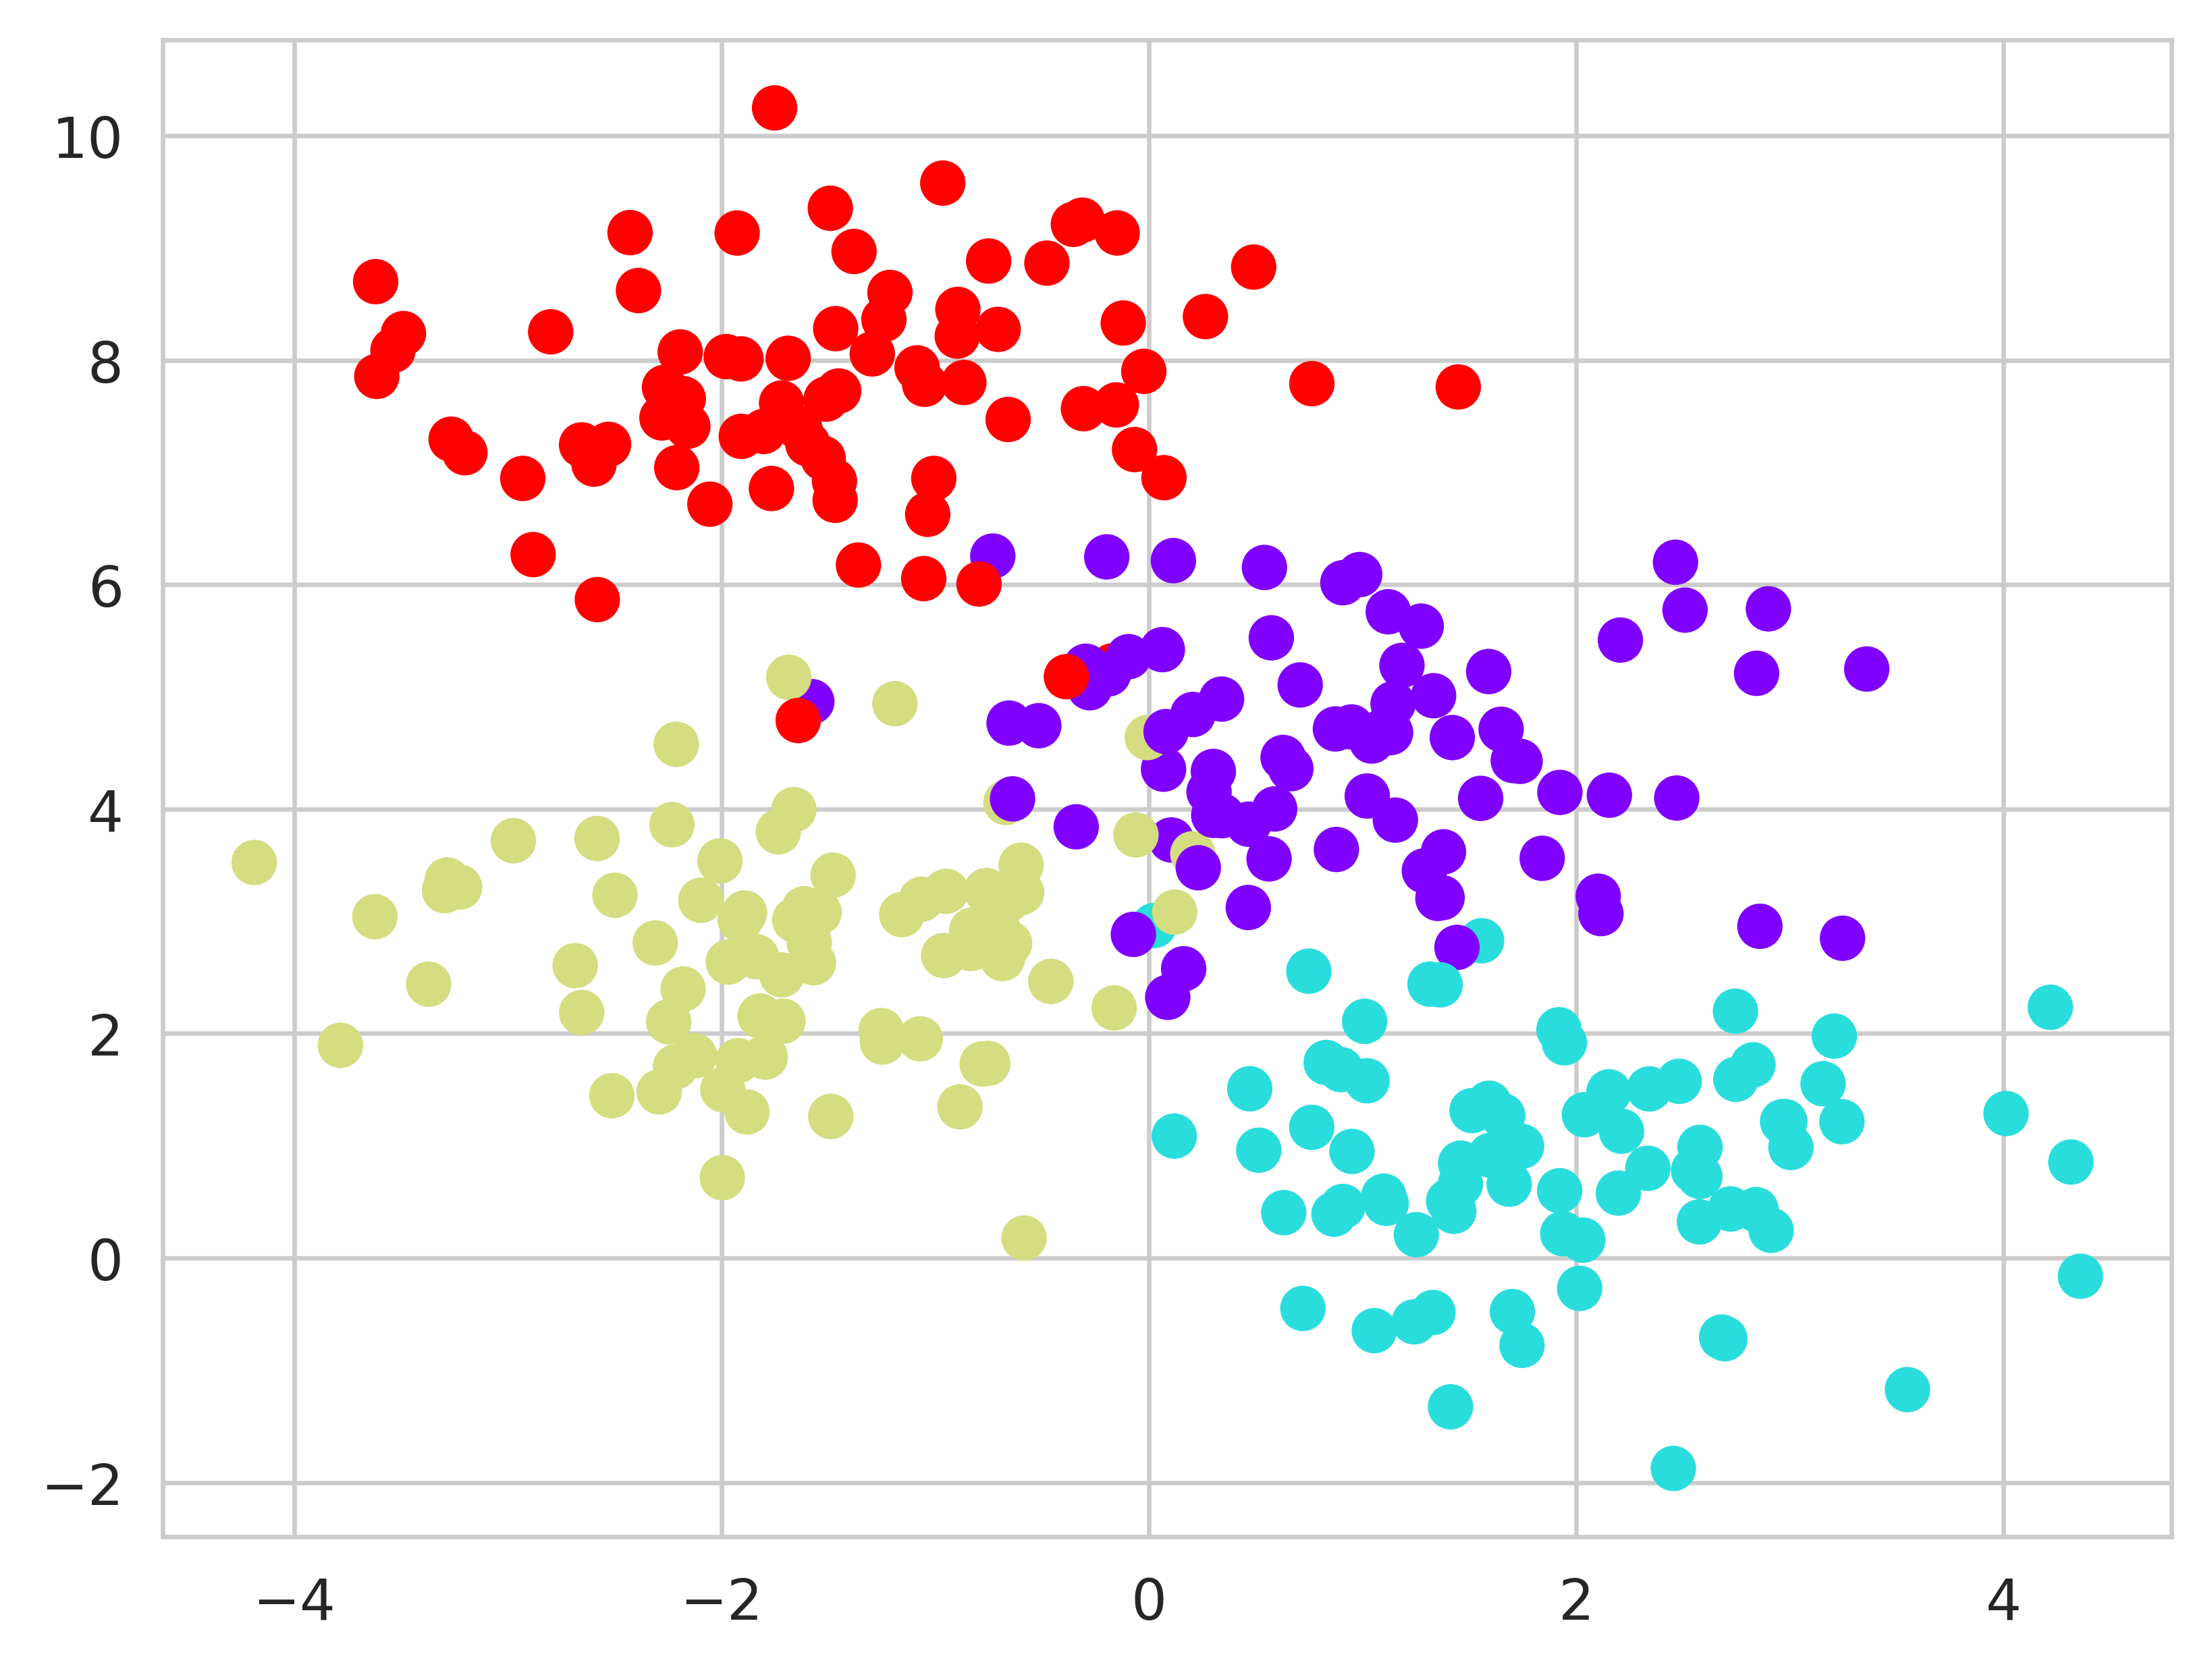

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');


A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
The following figure presents a visualization of the first four levels of a decision tree classifier for this data.

Un árbol de decisión simple construido con estos datos dividirá iterativamente el conjunto de datos a lo largo de uno u otro eje según algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con una votación mayoritaria de los puntos dentro de ella.
La siguiente figura muestra una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

Observa que después de la primera división, cada punto en la rama superior permanece sin cambios, por lo que no hay necesidad de subdividir más esta rama. Excepto en los nodos que contienen puntos de un solo color, en cada nivel cada región se divide nuevamente a lo largo de una de las dos características.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

Este proceso de ajustar un árbol de decisión a nuestros datos puede realizarse en Scikit-Learn con el estimador ``DecisionTreeClassifier``:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a utility function to help us visualize the output of the classifier:

Escribamos una función auxiliar que nos ayude a visualizar la salida del clasificador:

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like (see the following figure):

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la figura siguiente):

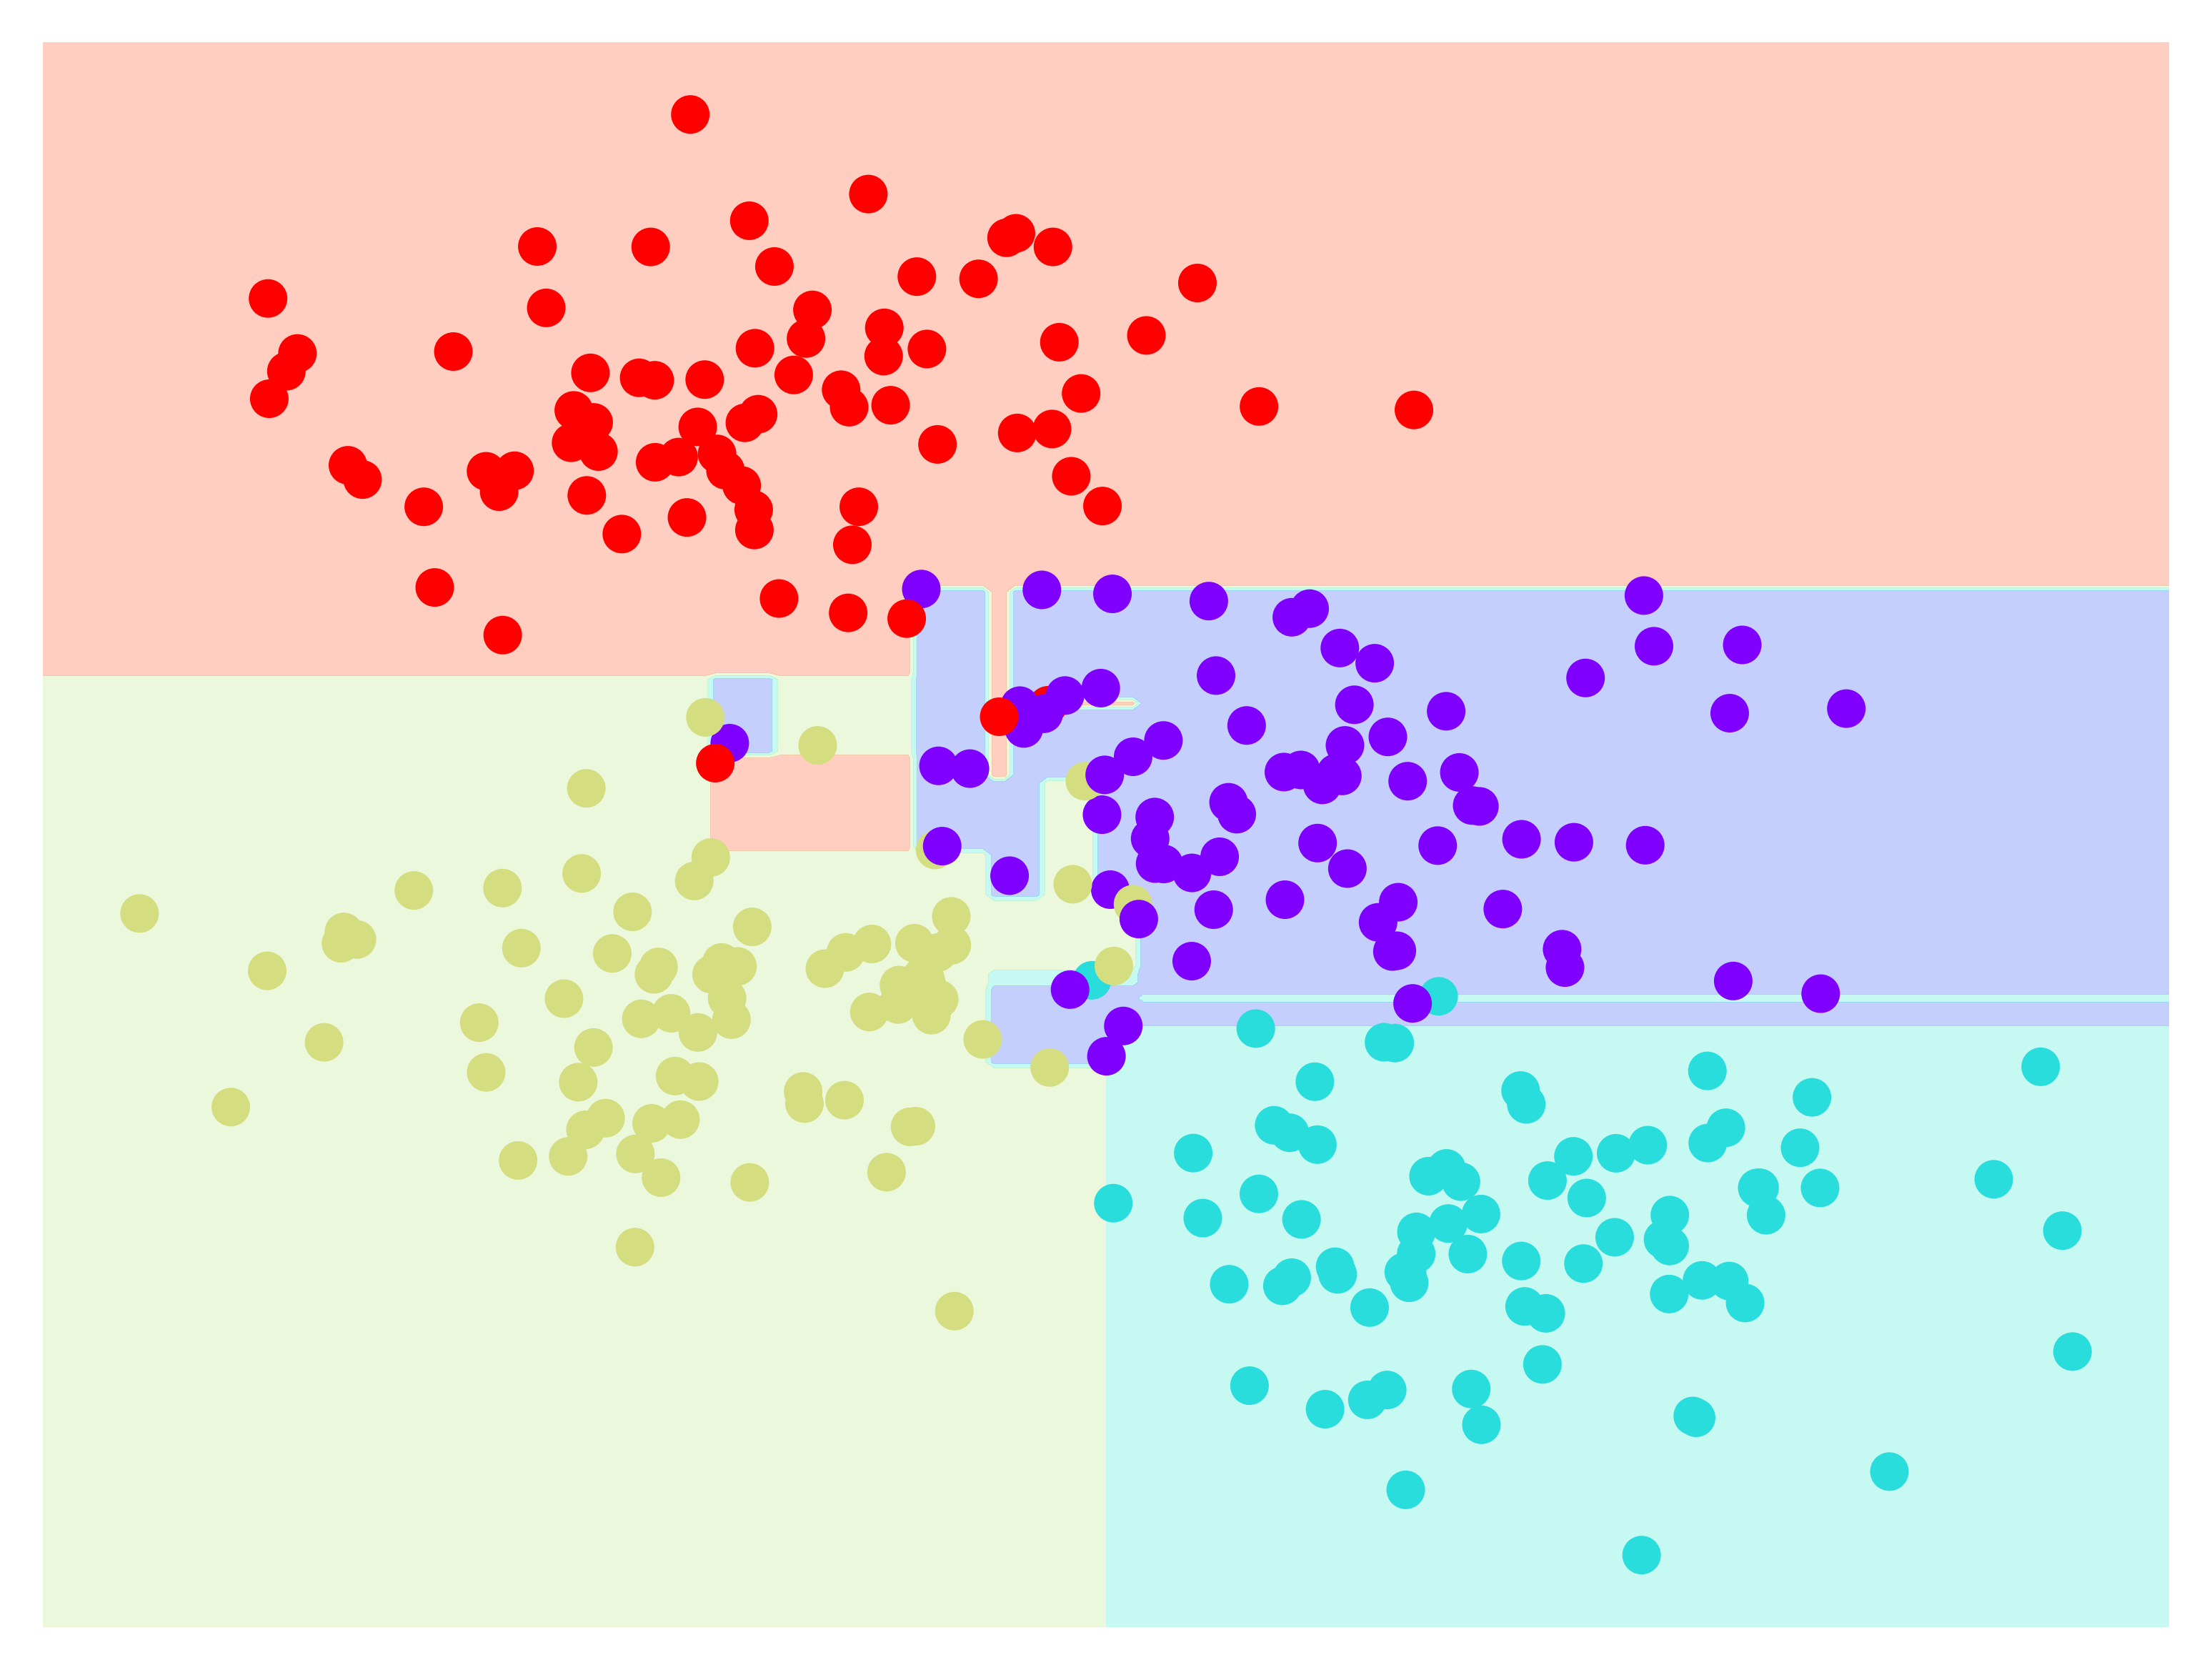

In [ ]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [ ]:

import helpers
helpers.plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly overfitting our data.

Observa que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación con formas muy extrañas; por ejemplo, con una profundidad de cinco, aparece una región púrpura alta y delgada entre las regiones amarilla y azul. Es claro que esto se debe menos a la verdadera distribución intrínseca de los datos y más a las propiedades particulares de muestreo o ruido del conjunto de datos. Es decir, este árbol de decisión, incluso con solo cinco niveles de profundidad, está claramente sobreajustando nuestros datos.

### Decision Trees and Overfitting

Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions it is drawn from.
Another way to see this overfitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data.

### Árboles de decisión y sobreajuste

Este sobreajuste resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar detalles específicos del conjunto de datos en lugar de las propiedades generales de las distribuciones de las que provienen.
Otra manera de ver este sobreajuste es observar modelos entrenados con diferentes subconjuntos de los datos; por ejemplo, en esta figura entrenamos dos árboles distintos, cada uno con la mitad de los datos originales.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

It is clear that in some places the two trees produce consistent results (e.g., in the four corners), while in other places the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

Es claro que en algunos lugares los dos árboles producen resultados coherentes (por ejemplo, en las cuatro esquinas), mientras que en otros lugares los dos árboles dan clasificaciones muy diferentes (por ejemplo, en las regiones entre dos clústeres cualquiera).
La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura, ¡y por lo tanto, al utilizar la información de ambos árboles, podríamos obtener un mejor resultado!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

Si estás ejecutando este cuaderno en vivo, la siguiente función te permitirá mostrar de manera interactiva los ajustes de los árboles entrenados en un subconjunto aleatorio de los datos:

In [ ]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

Así como usar información de dos árboles mejora nuestros resultados, podríamos esperar que usar información de muchos árboles los mejore aún más.

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here (see the following figure):

## Conjuntos de Estimadores: Random Forests

Esta idea —que múltiples estimadores sobreajustados pueden combinarse para reducir el efecto de este sobreajuste— es la base de un método de ensamble llamado *bagging*.
El bagging utiliza un conjunto (ensemble) de estimadores paralelos, cada uno de los cuales sobreajusta los datos, y promedia los resultados para obtener una clasificación mejor.
Un conjunto de árboles de decisión aleatorizados se conoce como un *random forest*.

Este tipo de clasificación mediante bagging puede realizarse manualmente usando Scikit-Learn's `BaggingClassifier` meta-estimator, como se muestra aquí (ver la figura siguiente):

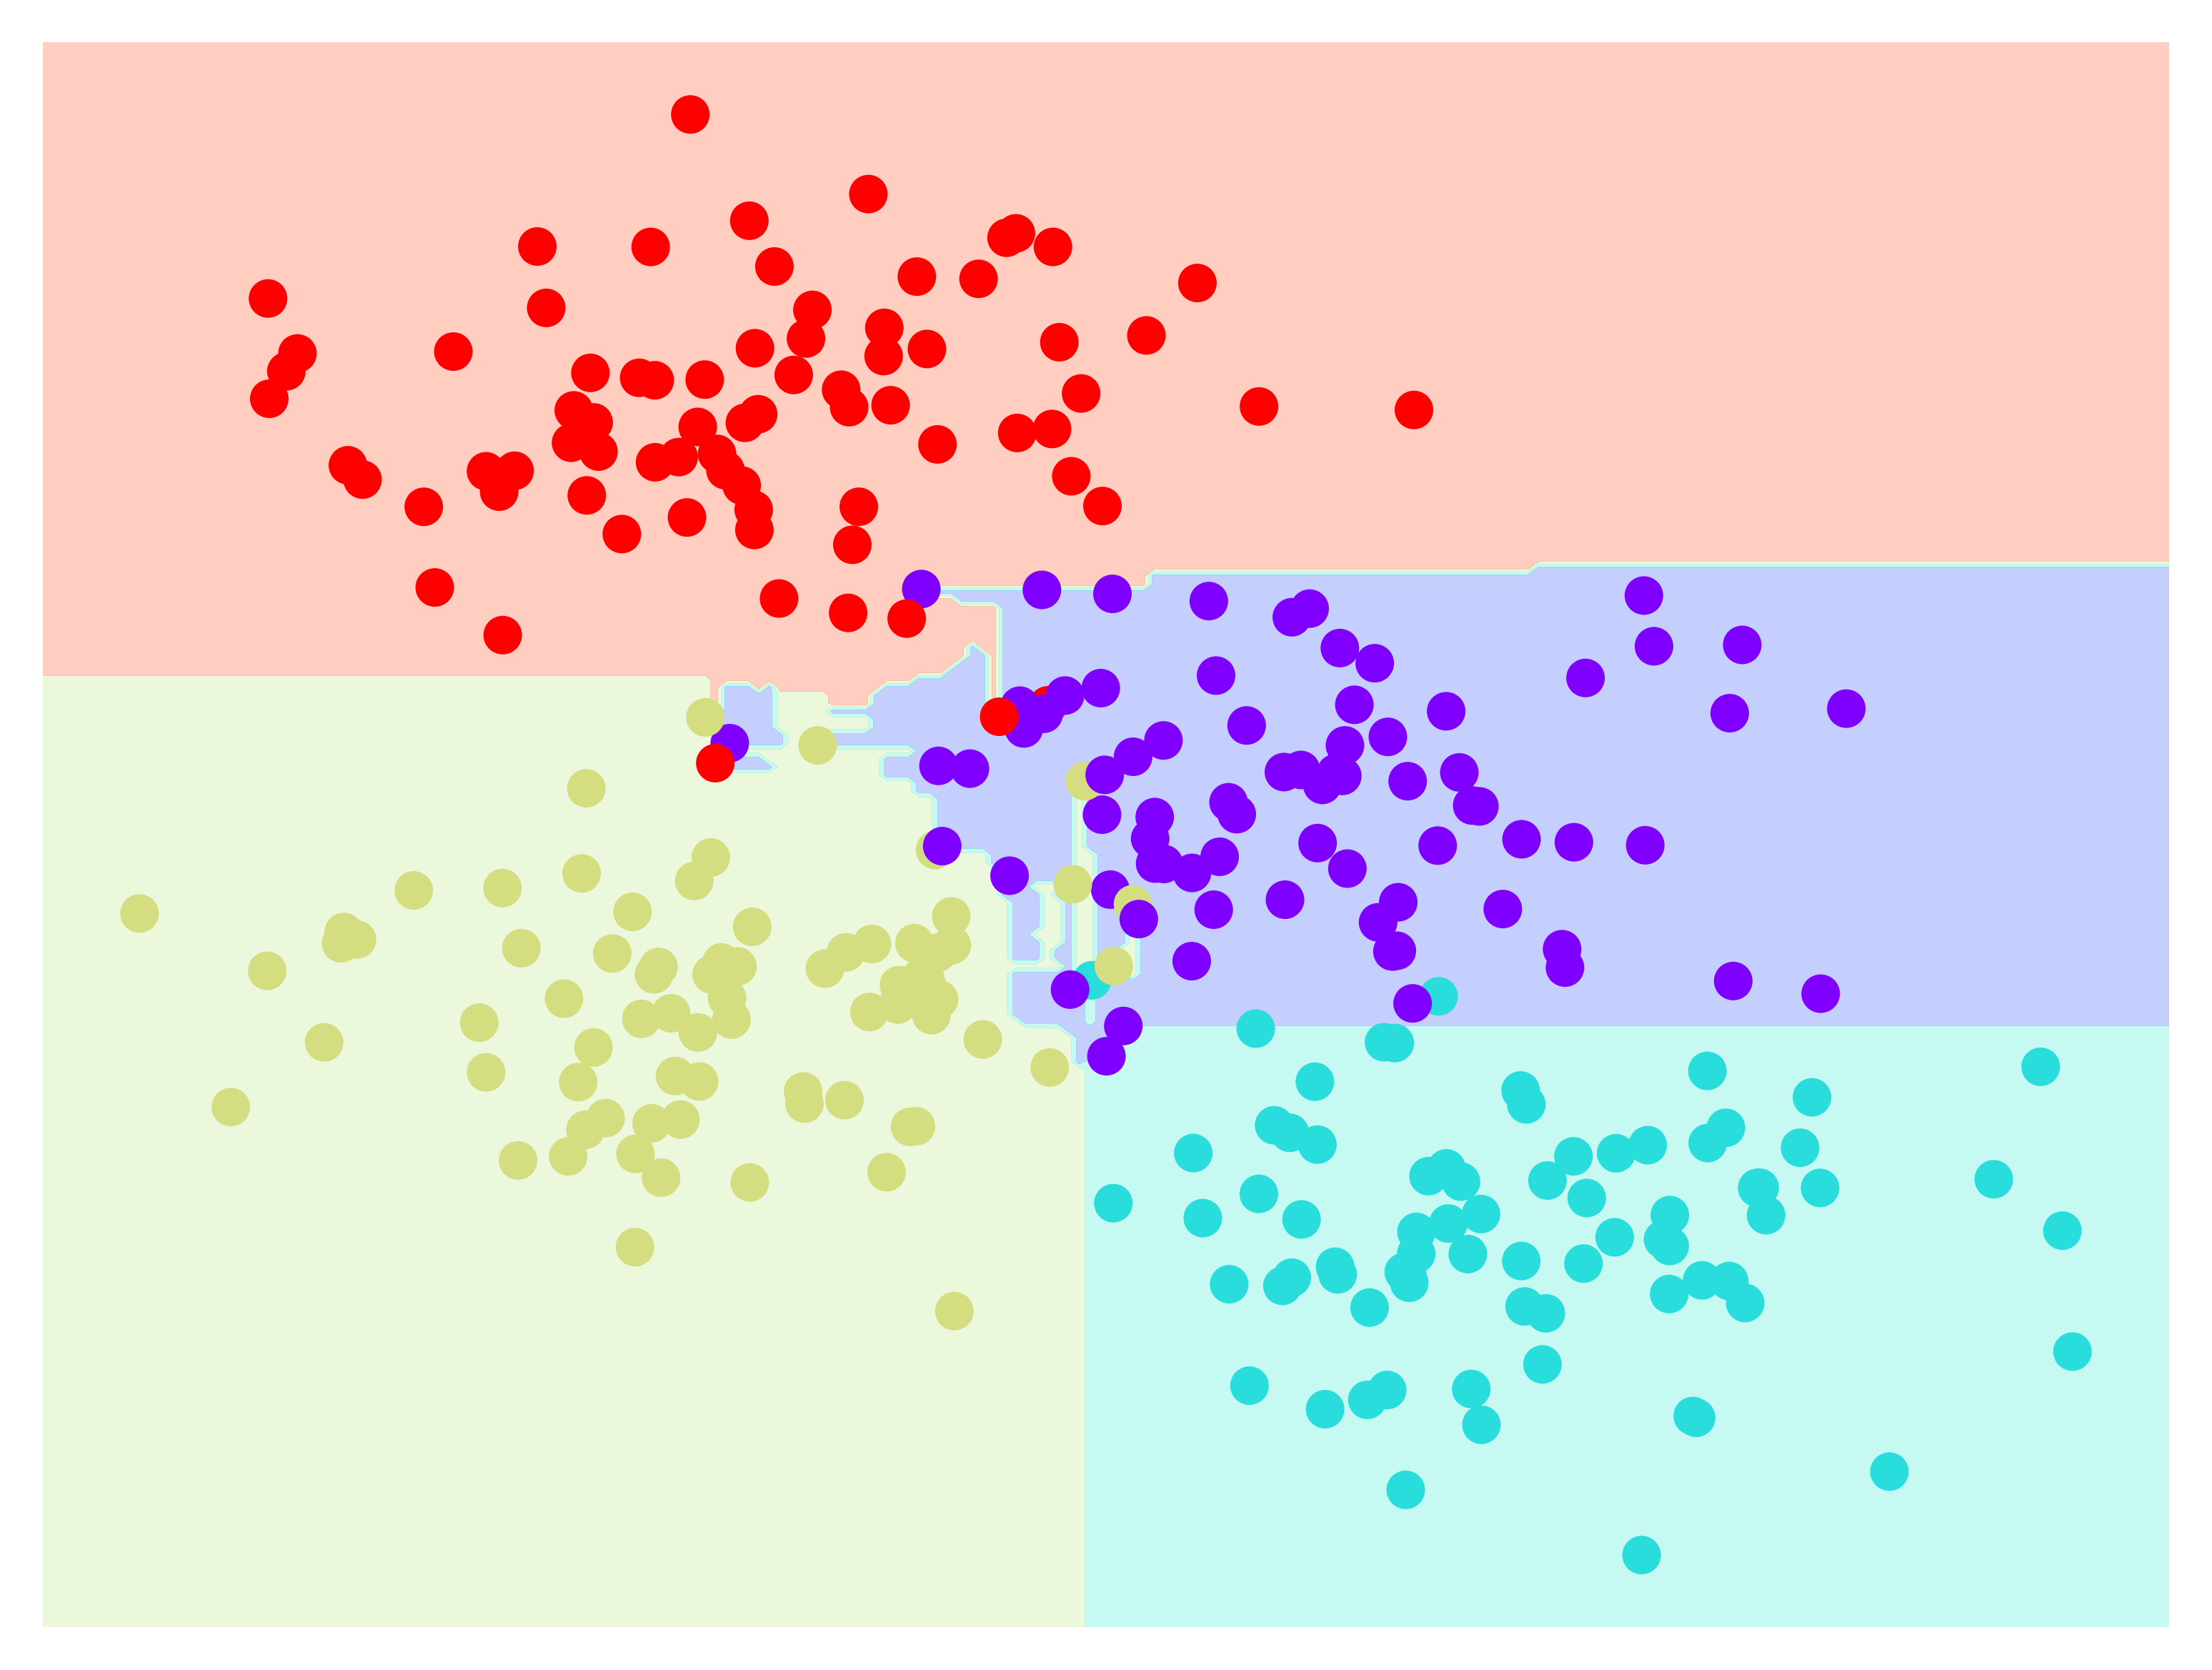

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly—in parallel, if desired—fit the ensemble of trees (see the following figure):

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80% de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de manera más efectiva inyectando algo de aleatoriedad en cómo se eligen las divisiones: de esta forma, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste conservan la aleatoriedad deseada.
Por ejemplo, al determinar qué característica usar para dividir, el árbol aleatorizado podría seleccionar entre las principales características.
Puedes leer más detalles técnicos sobre estas estrategias de aleatorización en la documentación [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) y en las referencias allí citadas.

En Scikit-Learn, un ensamble optimizado de árboles de decisión aleatorizados se implementa en el estimador `RandomForestClassifier`, que se encarga de toda la aleatorización automáticamente.
Todo lo que necesitas hacer es seleccionar un número de estimadores, y el algoritmo ajustará rápidamente—en paralelo si se desea—el conjunto de árboles (ver la figura siguiente):

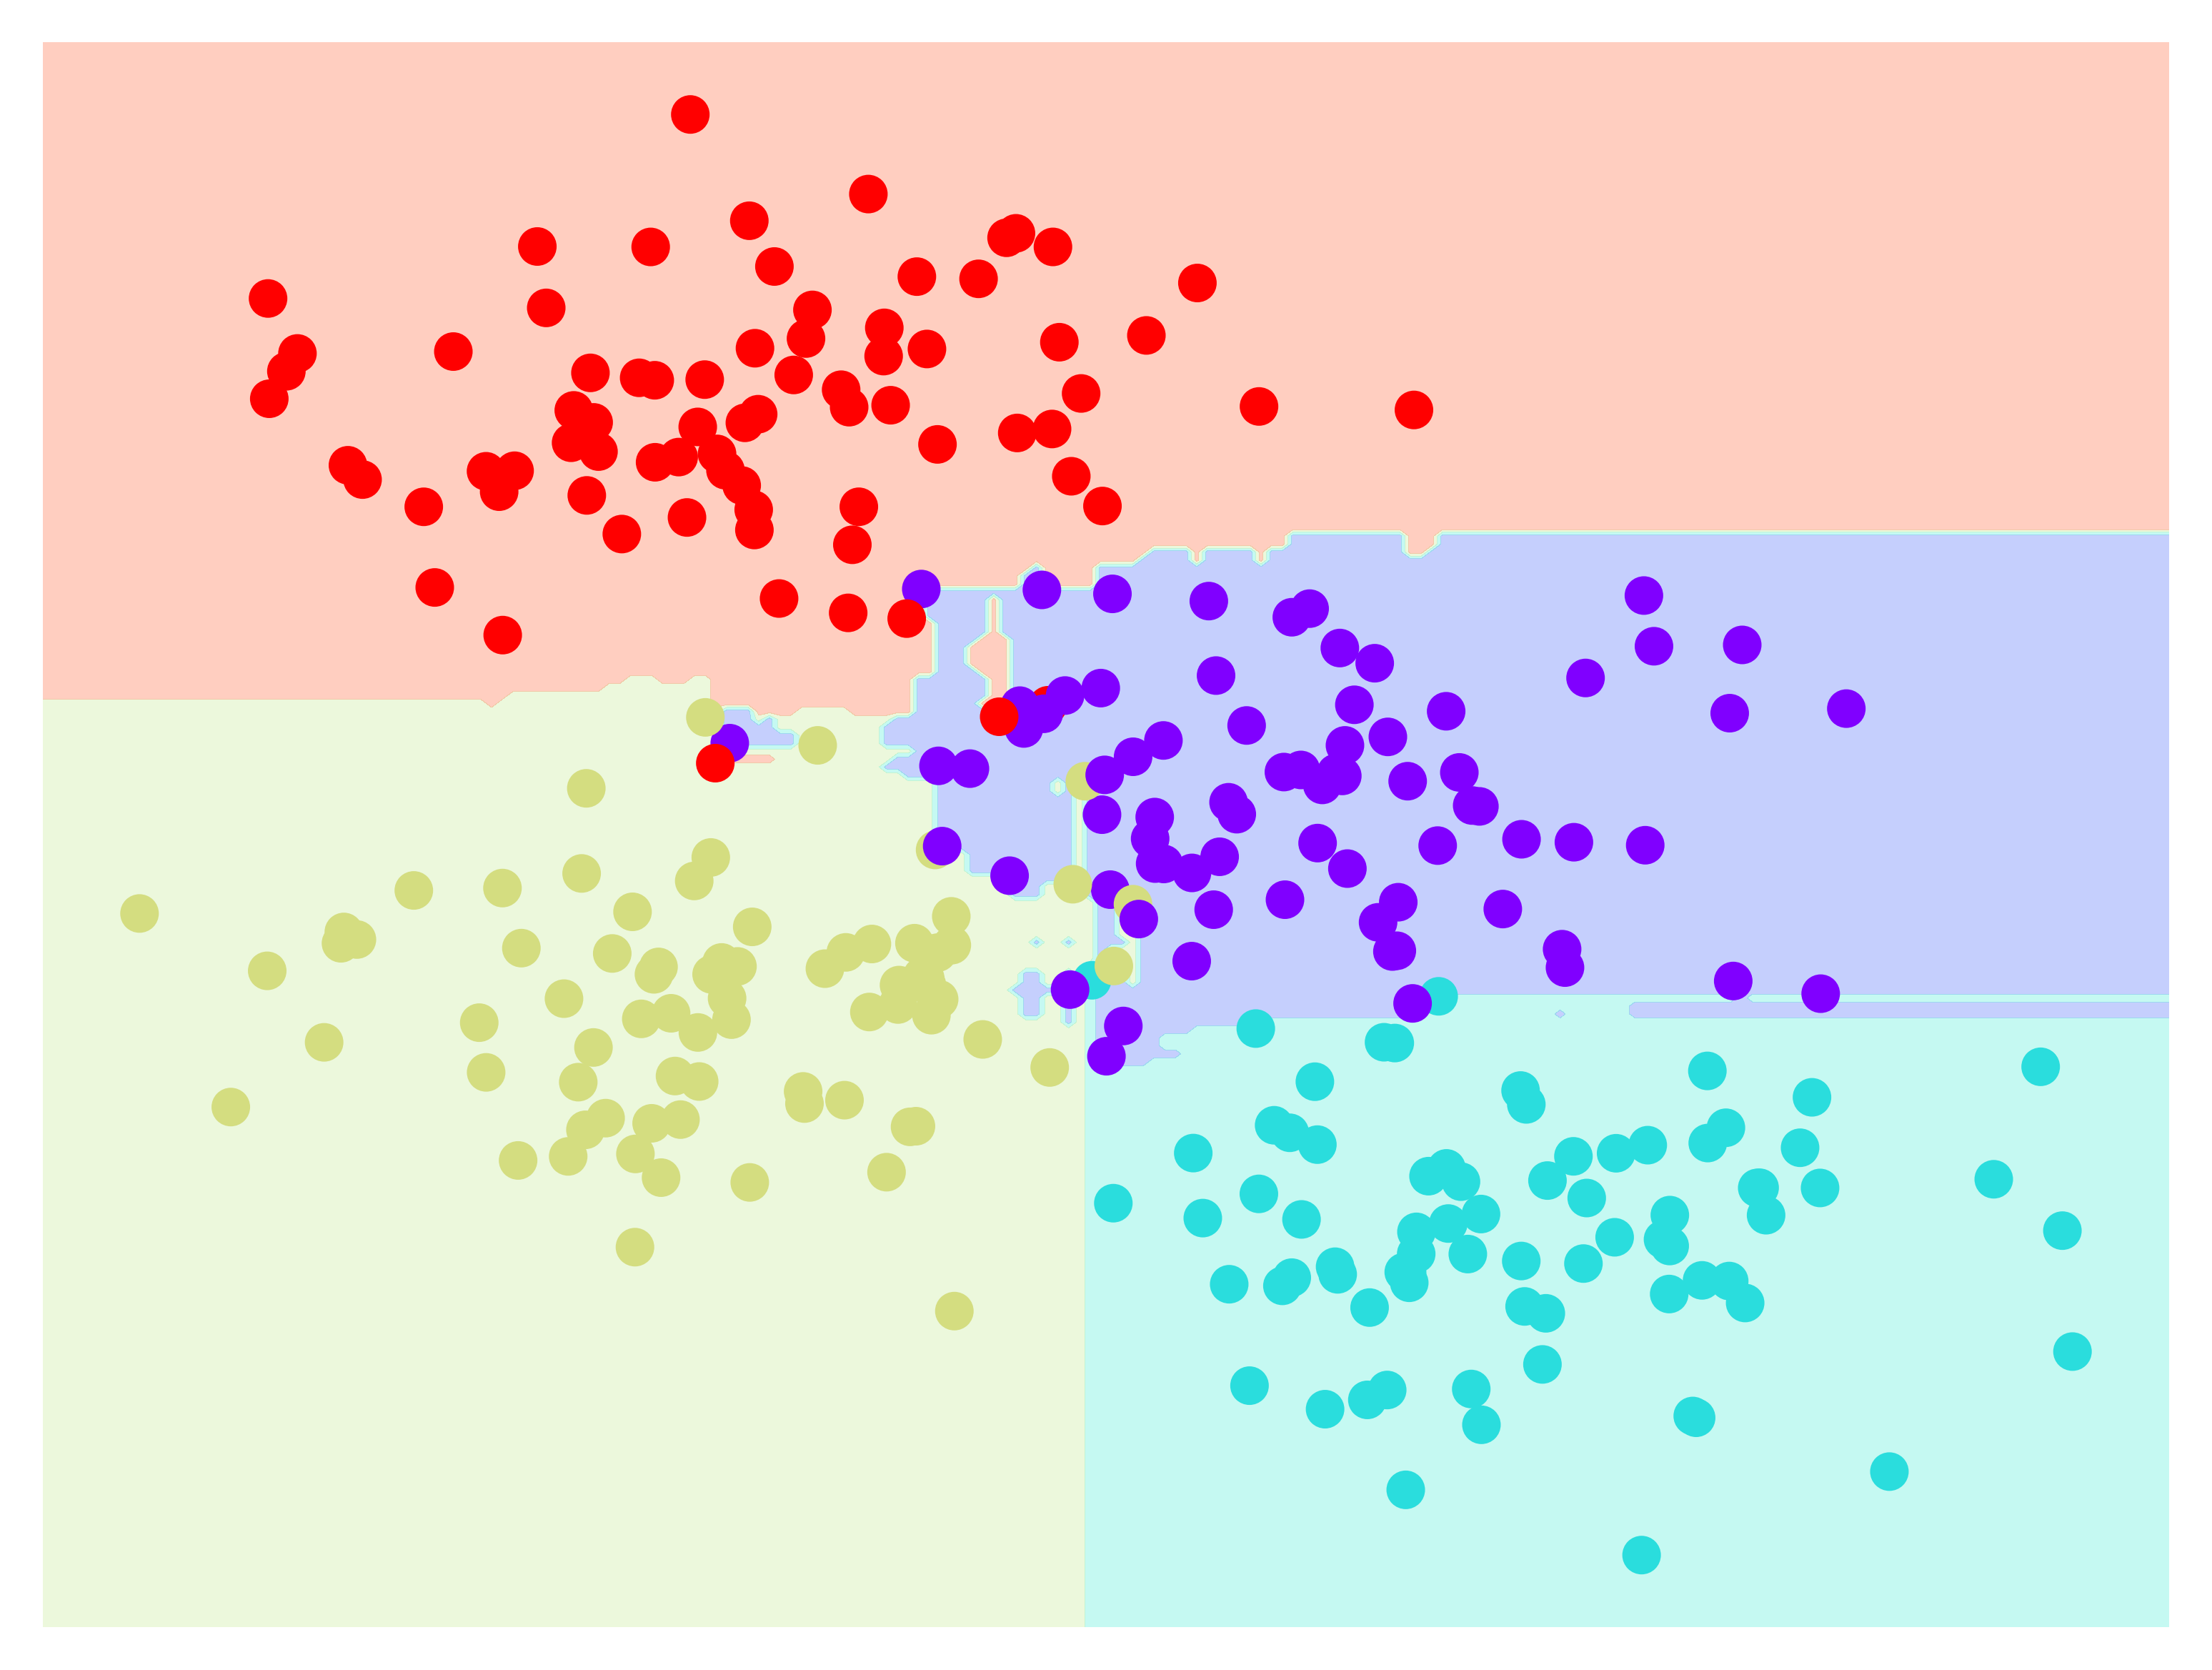

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

Vemos que al promediar sobre 100 modelos aleatoriamente perturbados, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo debería dividirse el espacio de parámetros.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, with continuous rather than categorical variables). The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation (see the following figure):

## Regresión con Random Forest

En la sección anterior consideramos los random forests en el contexto de la clasificación.
Los random forests también pueden aplicarse en el caso de la regresión (es decir, con variables continuas en lugar de categóricas). El estimador que se utiliza para esto es el `RandomForestRegressor`, y la sintaxis es muy similar a la que vimos anteriormente.

Consideremos los siguientes datos, generados a partir de la combinación de una oscilación rápida y una lenta (ver la figura siguiente):

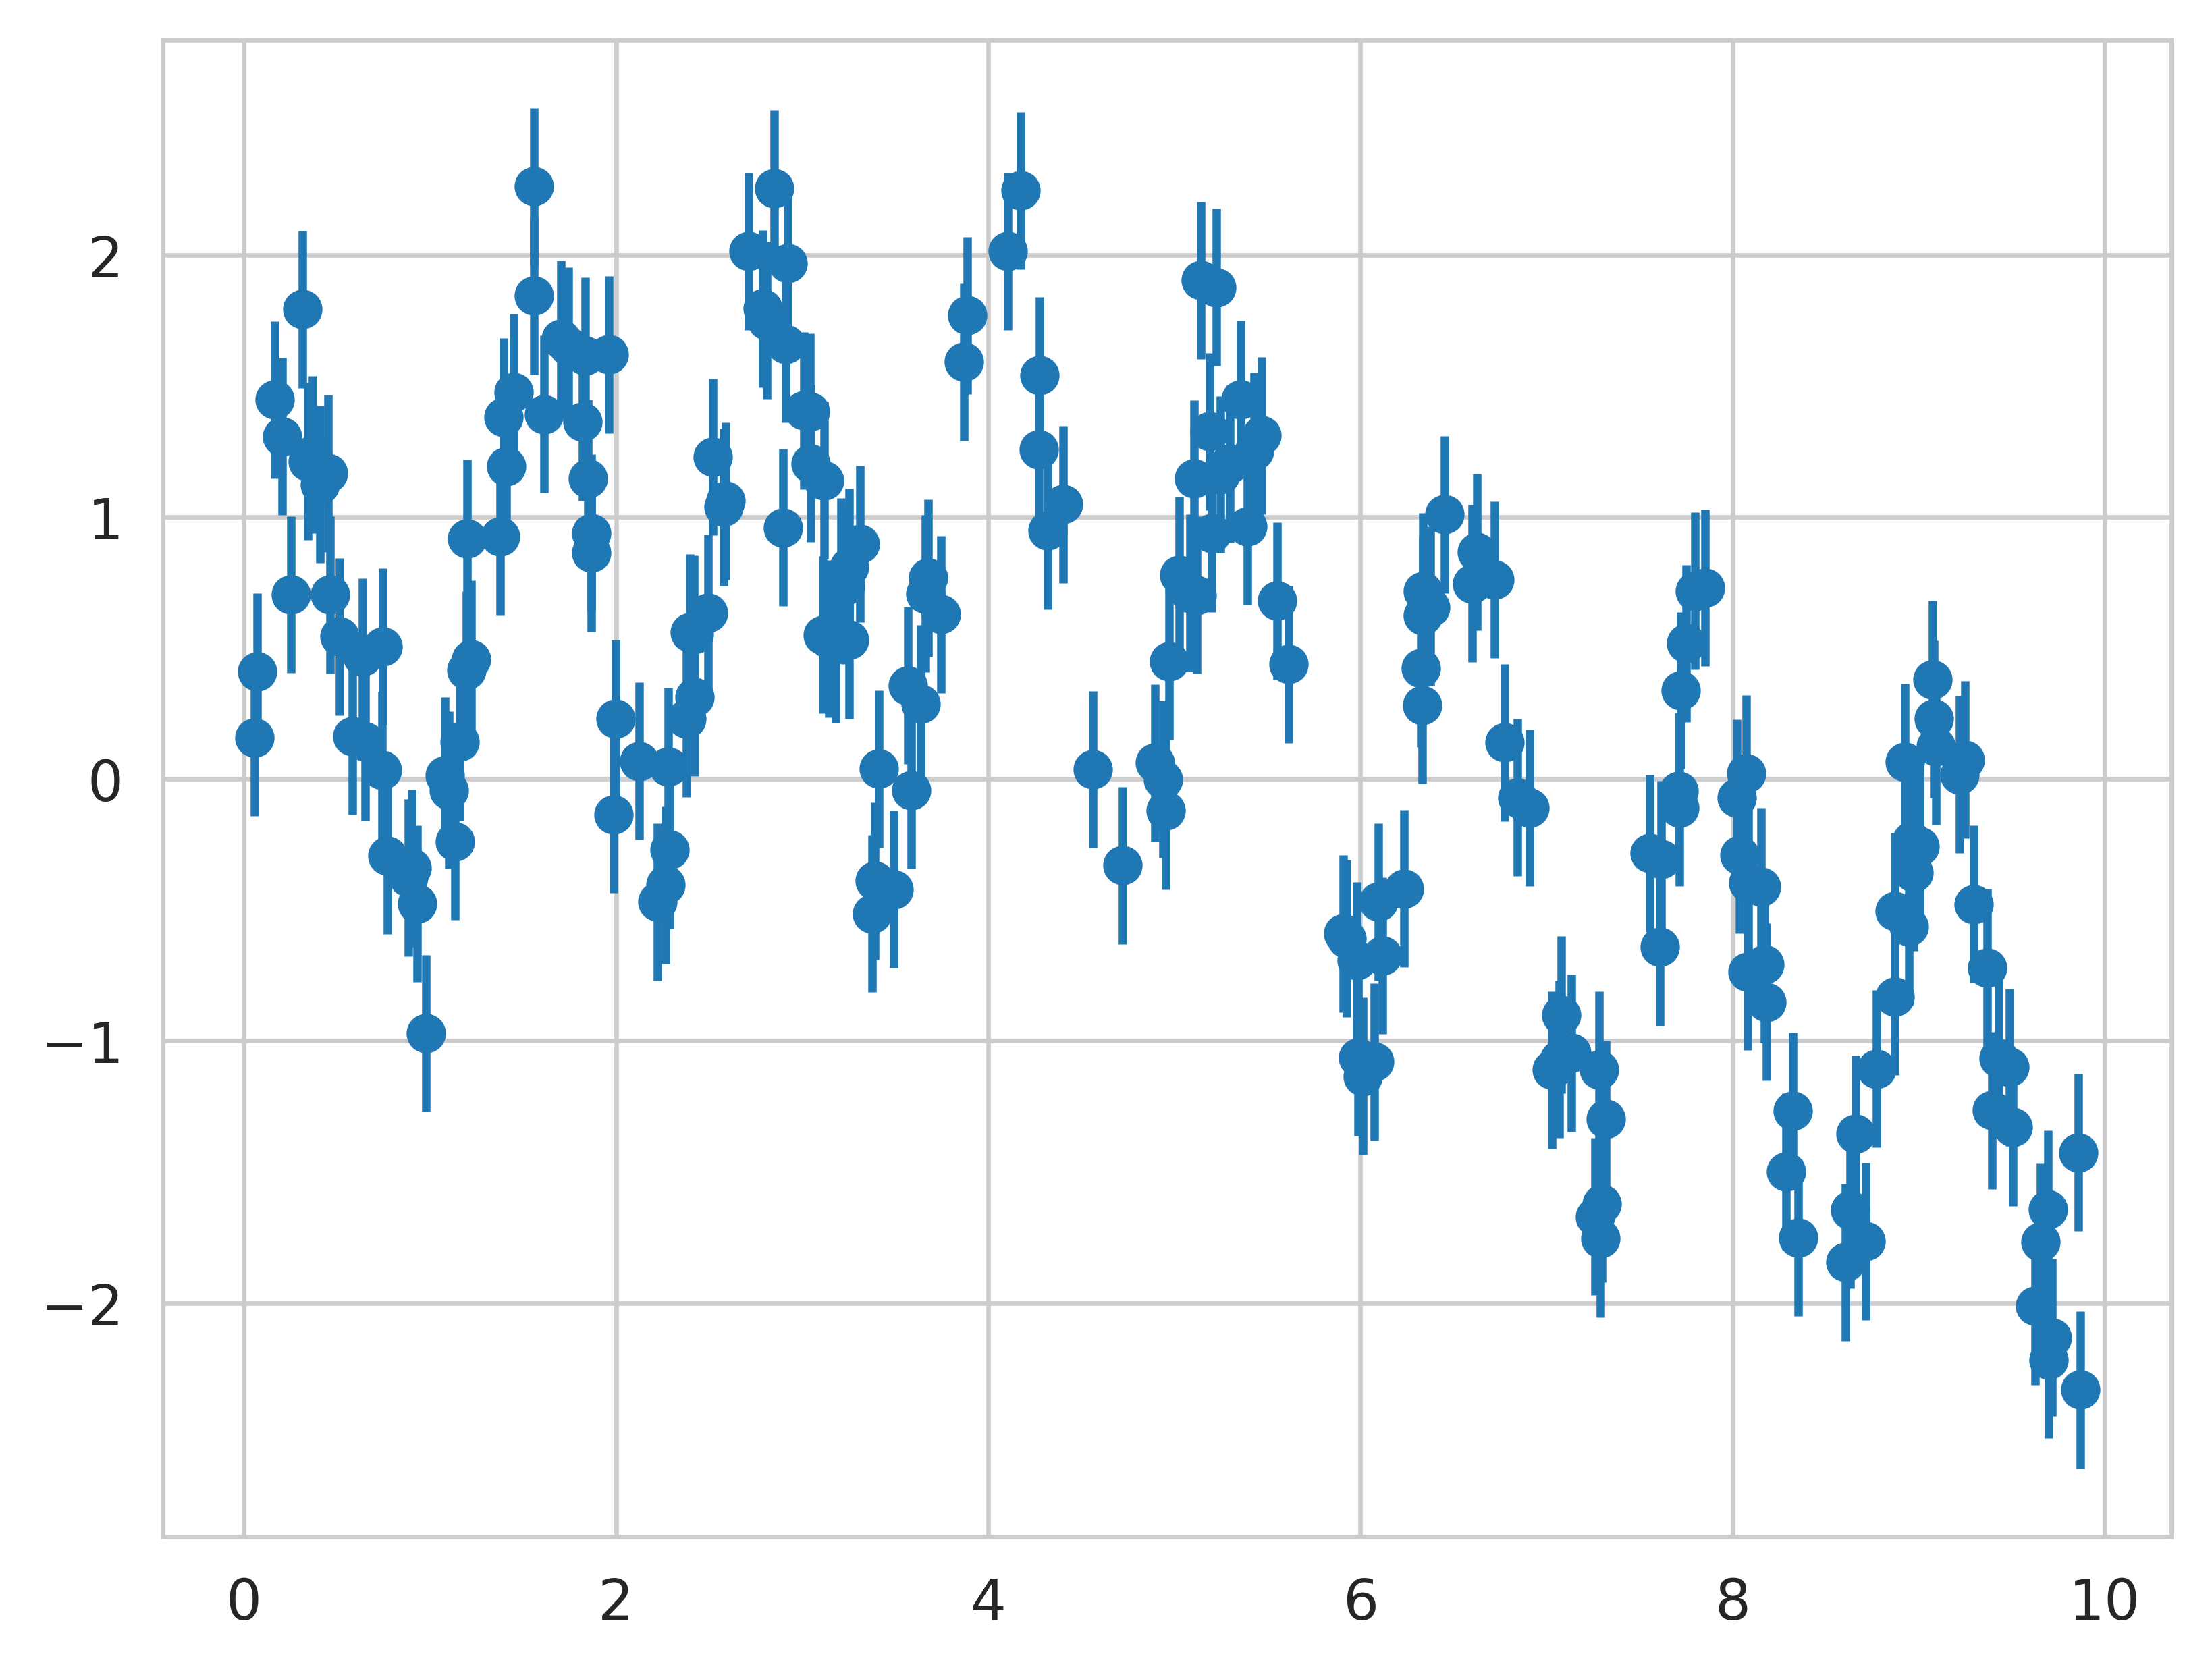

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best-fit curve as follows (see the following figure):

Usando el random forest regressor, podemos encontrar la curva de mejor ajuste de la siguiente manera (ver la figura siguiente):

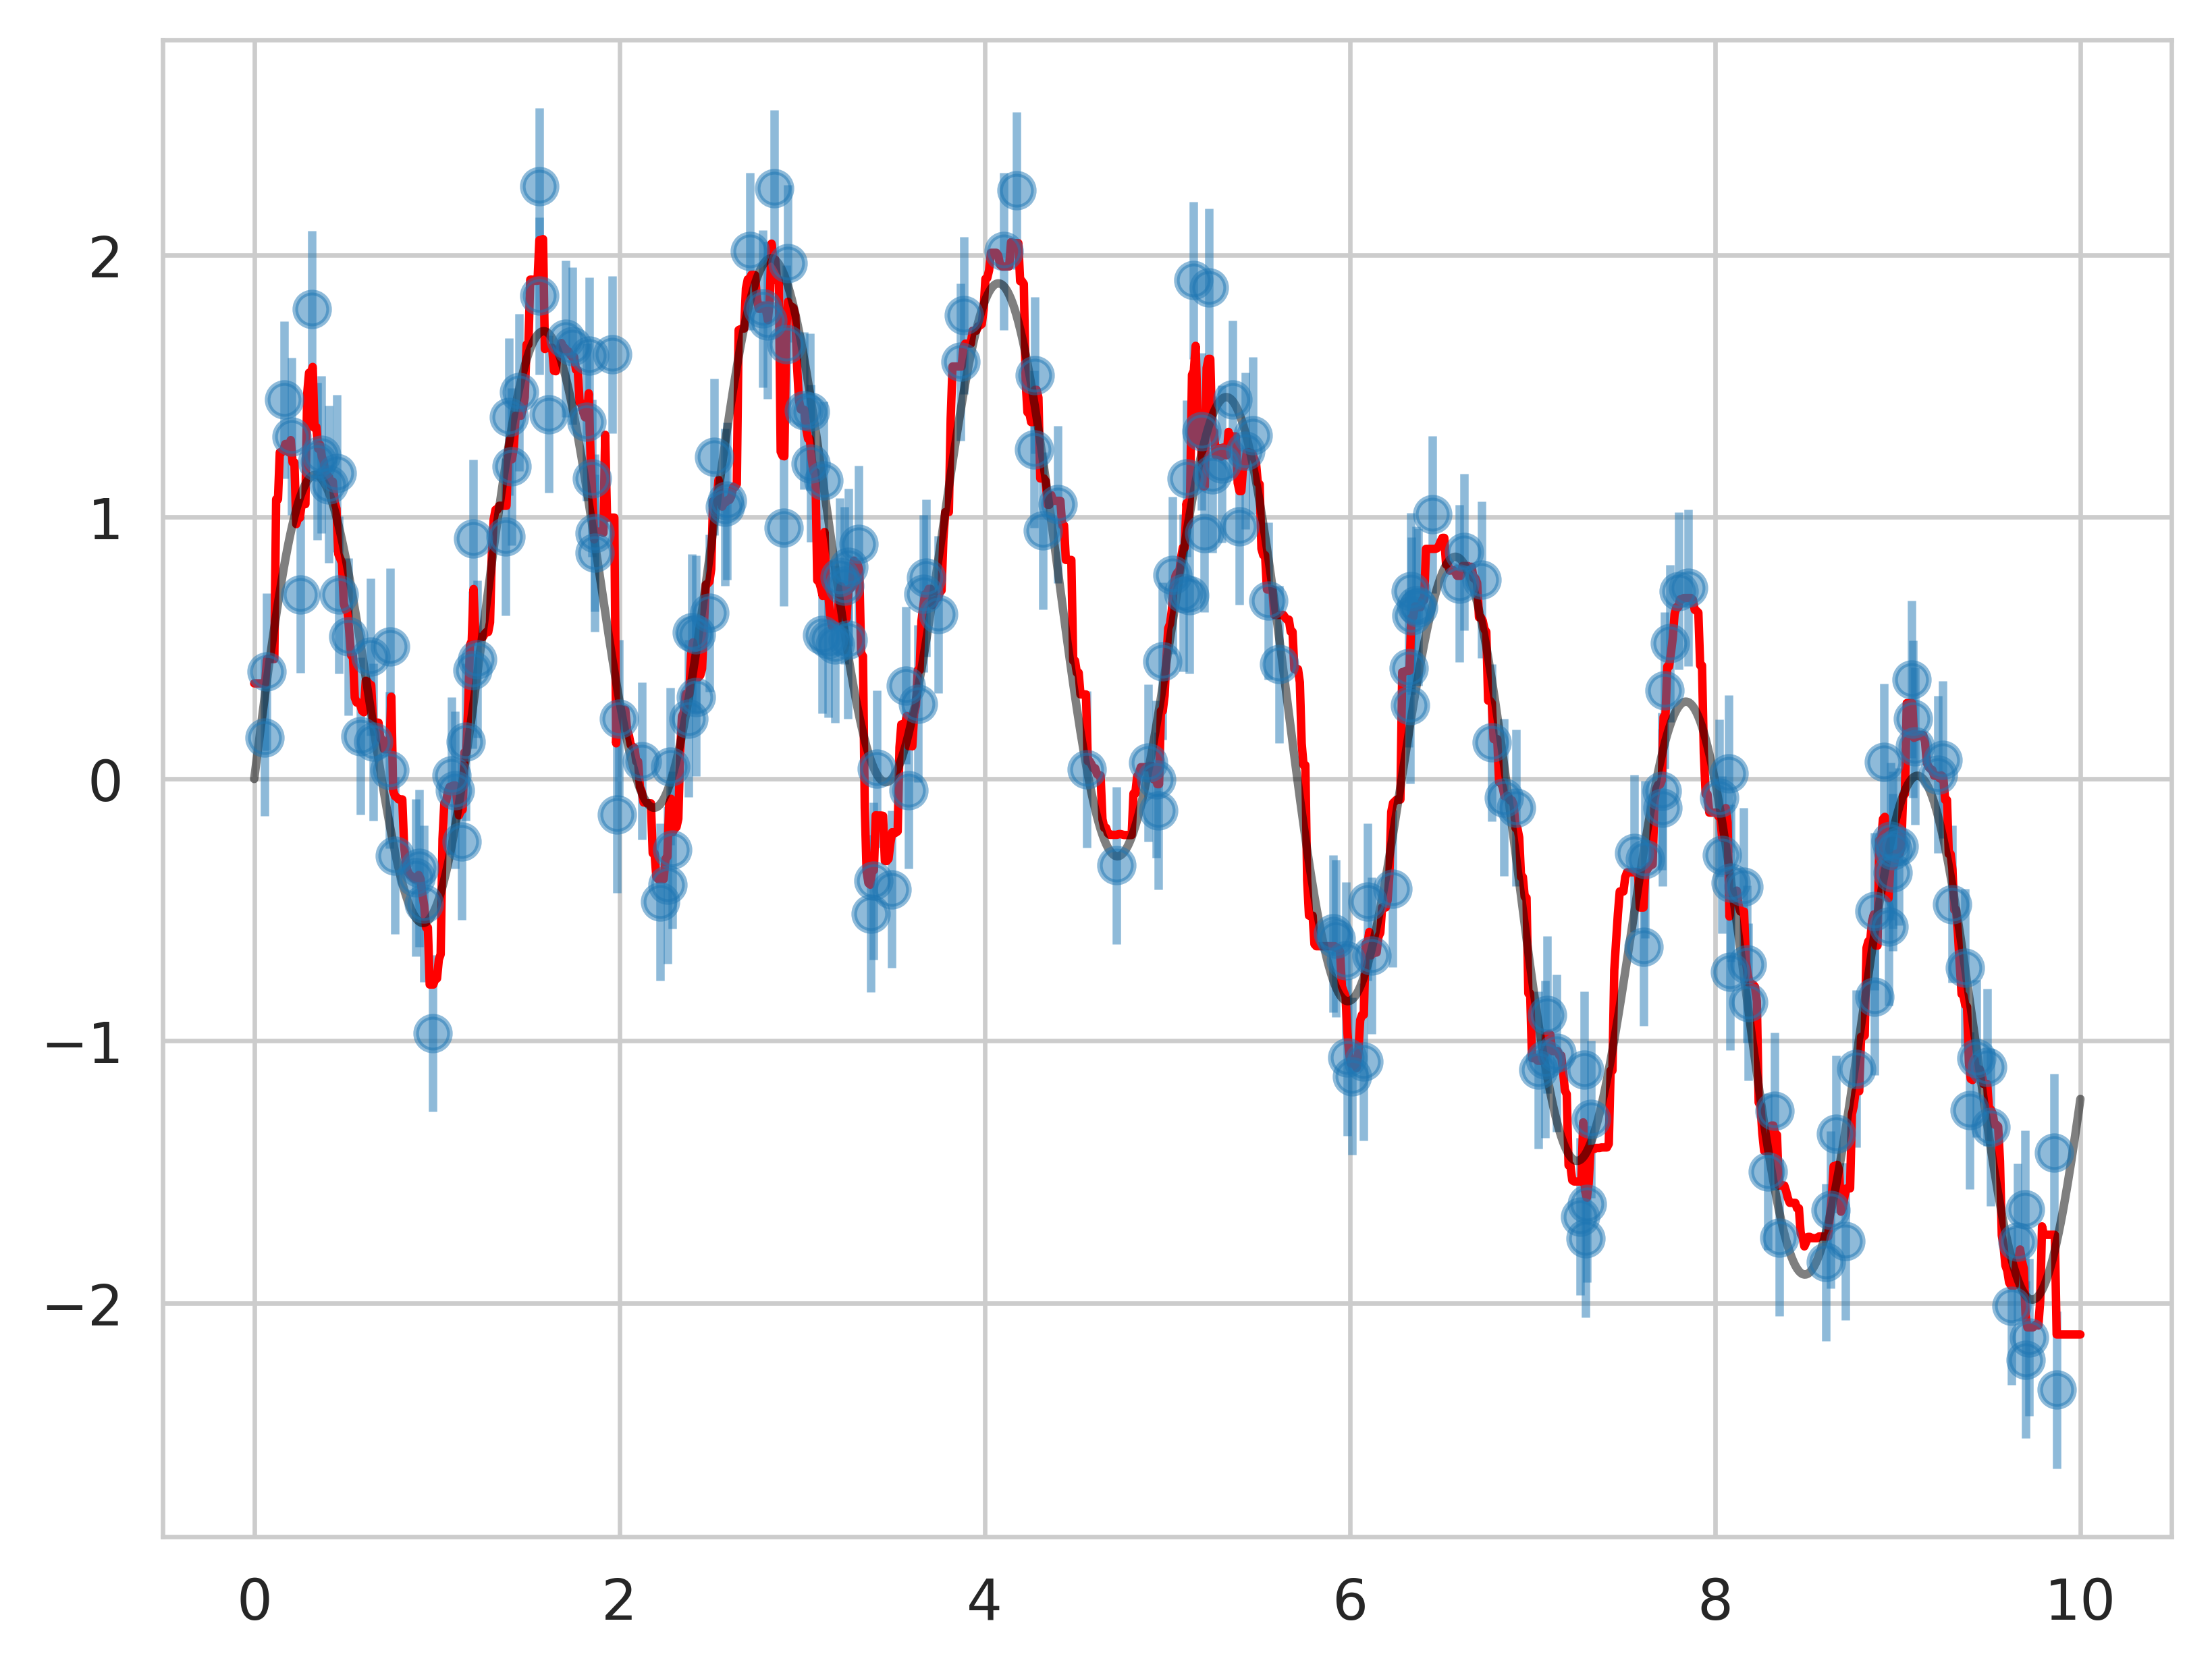

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
The nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multi-period model!

Aquí, el modelo verdadero se muestra con la curva gris suave, mientras que el modelo de random forest se muestra con la curva roja irregular.
El modelo no paramétrico de random forest es lo suficientemente flexible como para ajustarse a los datos multiperiodo, ¡sin que necesitemos especificar un modelo de múltiples periodos!

## Example: Random Forest for Classifying Digits

In Chapter 38 we worked through an example using the digits dataset included with Scikit-Learn.
Let's use that again here to see how the random forest classifier can be applied in this context:

## Ejemplo: Random Forest para Clasificar Dígitos

En el Capítulo 38 trabajamos un ejemplo usando el conjunto de datos de dígitos incluido en Scikit-Learn.
Usemos ese conjunto nuevamente aquí para ver cómo se puede aplicar el clasificador random forest en este contexto:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points (see the following figure):

Para recordarnos qué estamos observando, visualizaremos los primeros puntos de datos (ver la figura siguiente):

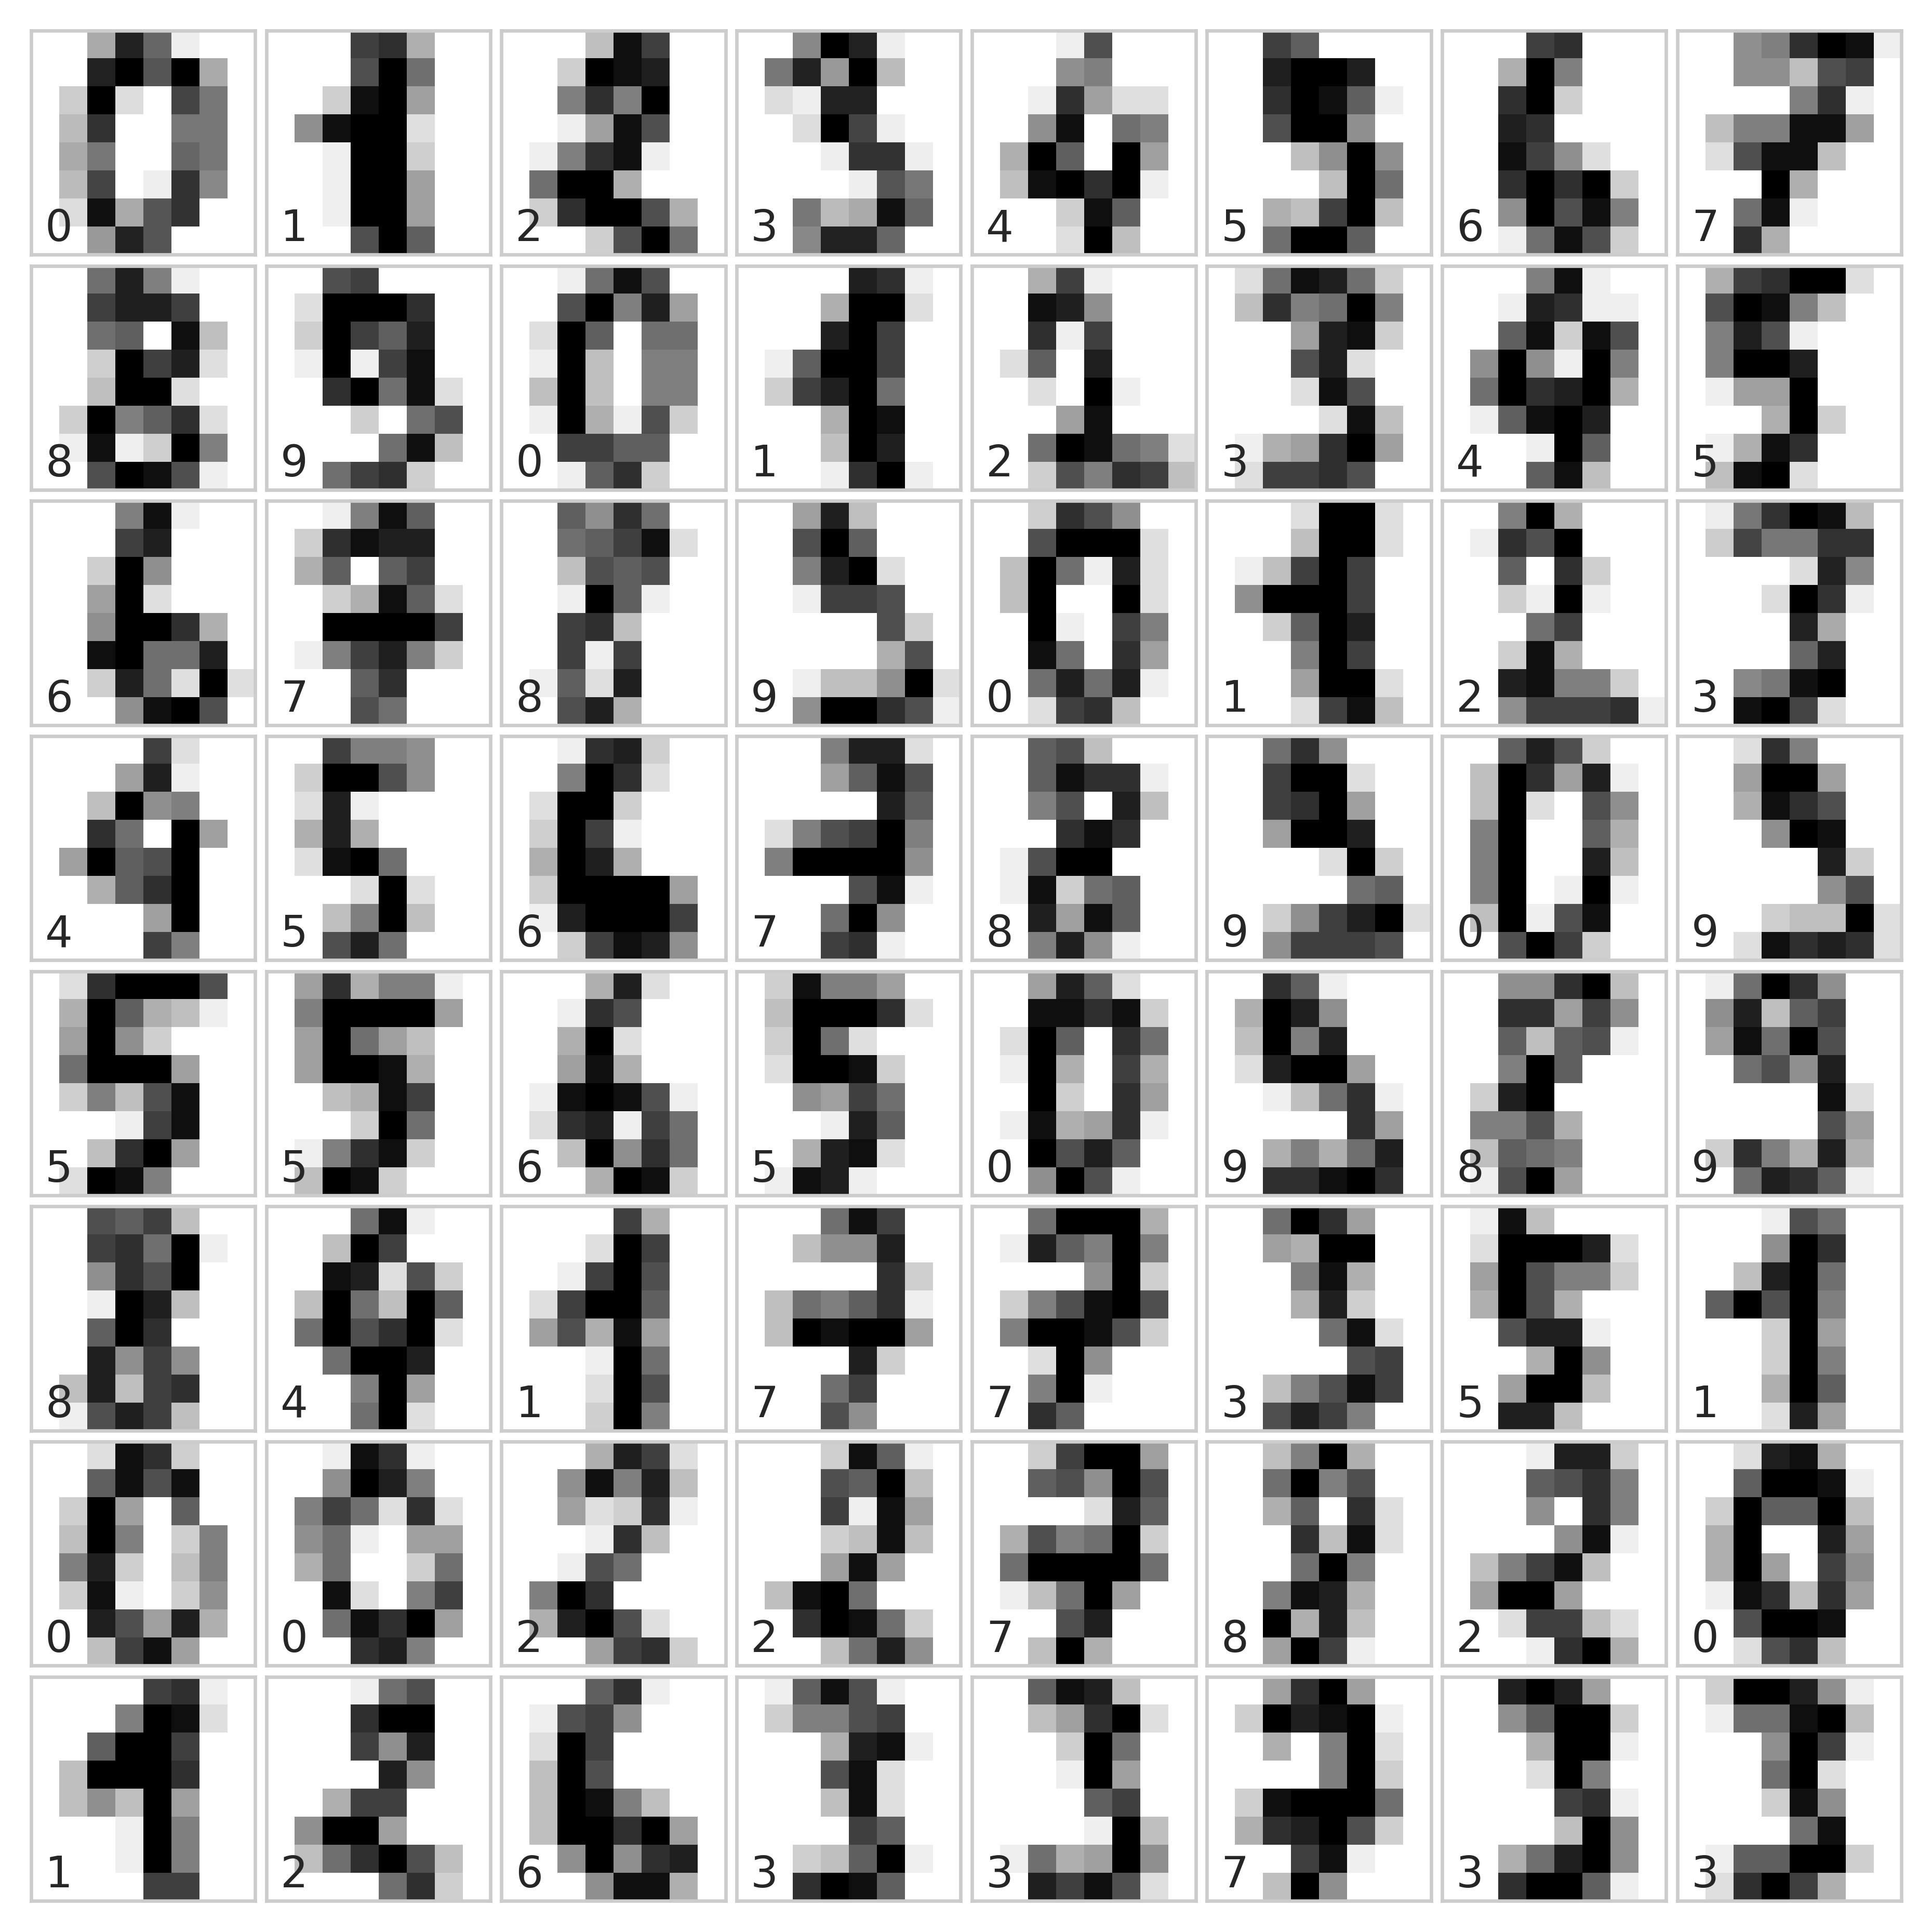

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can classify the digits using a random forest as follows:

Podemos clasificar los dígitos usando un random forest de la siguiente manera:

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Let's look at the classification report for this classifier:

Veamos el informe de clasificación de este clasificador:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix (see the following figure):

Y, para mayor claridad, grafiquemos la matriz de confusión (ver la figura siguiente):

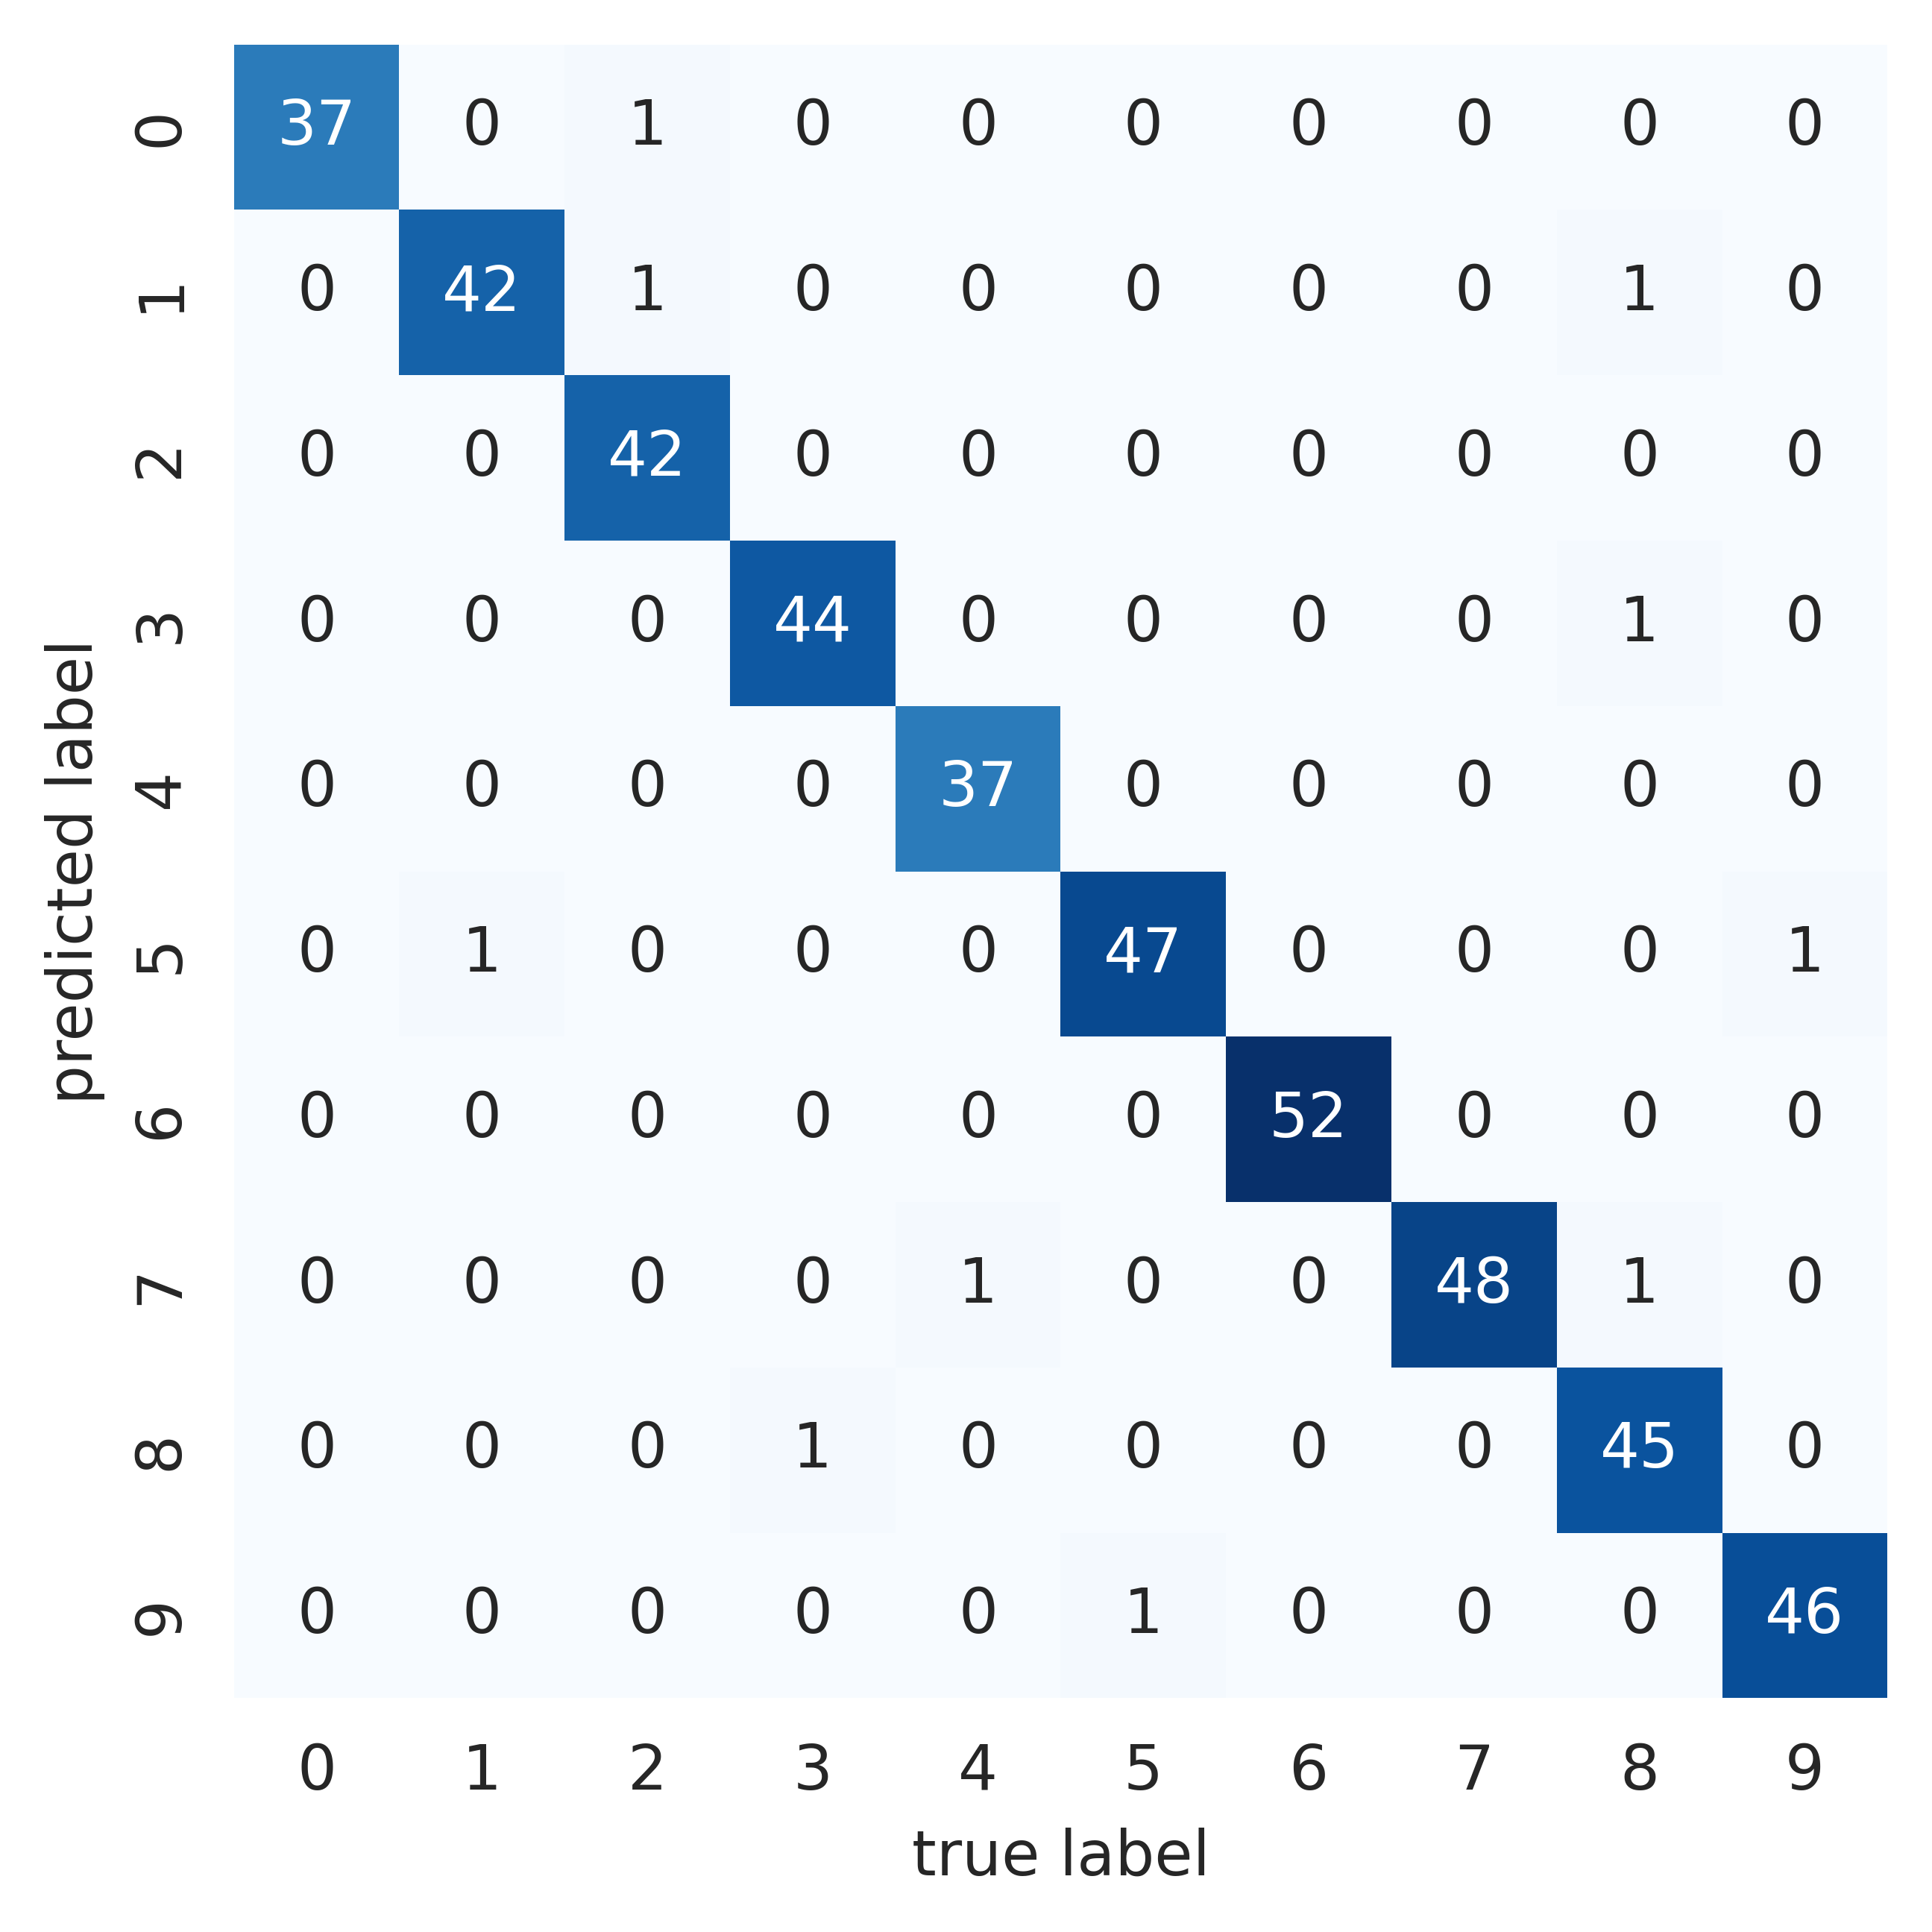

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a quite accurate classification of the digits data.

Encontramos que un random forest simple, sin ajustes, resulta en una clasificación bastante precisa del conjunto de datos de dígitos.

## Summary

This chapter provided a brief introduction to the concept of ensemble estimators, and in particular the random forest, an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the `predict_proba` method).
- The nonparametric model is extremely flexible and can thus perform well on tasks that are underfit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

## Resumen

Este capítulo proporcionó una breve introducción al concepto de estimadores en conjunto (ensemble estimators) y, en particular, al random forest, un ensamble de árboles de decisión aleatorizados. Los random forests son un método potente con varias ventajas:

Tanto el entrenamiento como la predicción son muy rápidos, debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas pueden paralelizarse de manera sencilla, ya que los árboles individuales son entidades completamente independientes.

La existencia de múltiples árboles permite una clasificación probabilística: un voto mayoritario entre los estimadores proporciona una estimación de la probabilidad (accesible en Scikit-Learn con el método predict_proba).

El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede desempeñarse bien en tareas que otros estimadores subajustan.

Una desventaja principal de los random forests es que los resultados no son fácilmente interpretables: es decir, si deseas extraer conclusiones sobre el significado del modelo de clasificación, los random forests pueden no ser la mejor opción.